In [1]:
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial

In [2]:
import numpy as np
from numpy import arange

In [3]:
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd 

import os

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, preprocessing, models, utils, applications, layers
from tensorflow.python.client import device_lib
import datetime

2022-11-06 21:22:25.852660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 21:22:26.110124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 21:22:26.110147: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-06 21:22:26.153393: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 21:22:27.487532: W tensorflow/stream_executor/platform/de

In [5]:
import os, random
import glob
import shutil


In [6]:
print("keras {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))

keras 2.10.0
tensorflow 2.10.0


In [7]:
tf.config.list_physical_devices('GPU')
device_lib.list_local_devices()

2022-11-06 21:22:29.327672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-06 21:22:29.327725: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-06 21:22:29.327756: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (paulo-Latitude-5490): /proc/driver/nvidia/version does not exist
2022-11-06 21:22:29.328084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15211085549971723646
 xla_global_id: -1]

In [8]:
downloaded_data_path = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/downloaded_data'
organized_data_path = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/organized_data'

destination_train = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/train'
destination_validation = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/validation'


In [9]:
# listing all files
files_path = []
for path in glob.glob(downloaded_data_path+'/*/*/*.jpg'):
    files_path.append(path)

# downloaded -> organized
for files in files_path:
    shutil.move(src=files, dst=organized_data_path)

# organized -> shuffle files -> train and validation
organized_files = os.listdir(organized_data_path)
organized_files = random.choices(organized_files, k = len(organized_files))

In [10]:
to_delete = True

if to_delete:

    num_skipped = 0
    
    folder_path_pet = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/organized_data'
    
    for fname in os.listdir(folder_path_pet):
        
        fpath = os.path.join(folder_path_pet, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [11]:
labels = []

for filename in organized_files:
    label = filename.split('_')[1].split('.')[0]
    if label == 'temp':
        labels.append(0)
    else:
        labels.append(1)

df = pd.DataFrame({
    'filename': organized_files,
    'label': labels
})

df

,filename,label
0,92000067_temp.jpg,0
1,20085000_temp.jpg,0
2,12300076_temp.jpg,0
3,77000007_test.jpg,1
4,00041188_test.jpg,1
...,...,...
2878,12300134_test.jpg,1
2879,12100021_temp.jpg,0
2880,20085177_test.jpg,1
2881,12300237_test.jpg,1


<AxesSubplot: >

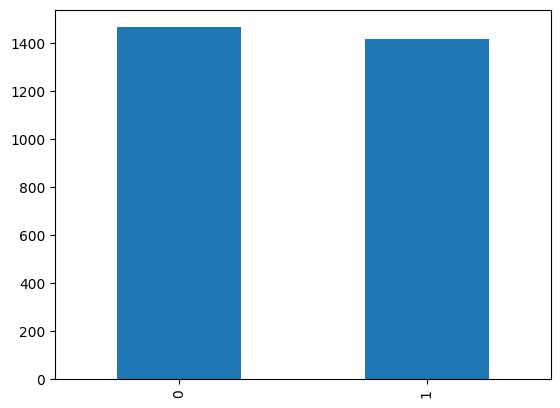

In [12]:
df['label'].value_counts().plot.bar()

In [13]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

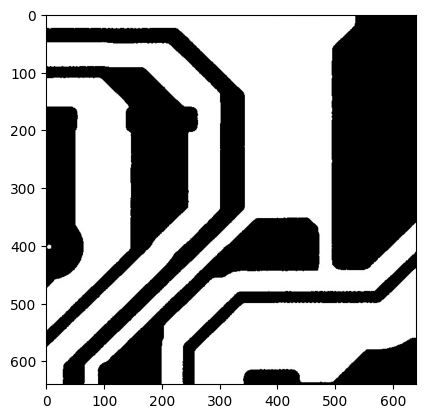

In [14]:
sample = random.choice(organized_files)
image = preprocessing.image.image_utils.load_img(organized_data_path+'/'+sample)
plt.imshow(image)

In [15]:
# plt.imshow(image)

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         #plt.title(int(labels[i]))
#         plt.axis("off")

In [16]:
base_model=applications.MobileNet(weights='imagenet',include_top=False)  #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(1024,activation='relu')(x)                          #we add dense layers so that the model can learn more complex functions and classify for better results.
x=layers.Dense(1024,activation='relu')(x)                          #dense layer 2
x=layers.Dense(512,activation='relu')(x)                           #dense layer 3
preds=layers.Dense(2,activation='softmax')(x)                      #final layer with softmax activation

In [17]:
model=models.Model(inputs=base_model.input,outputs=preds)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

In [19]:
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [22]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)

In [23]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [73]:
checkpoint_path = "/home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [74]:
callbacks = [earlystop, learning_rate_reduction, cp_callback]

In [25]:
df["label"] = df["label"].replace({0: 'Good', 1: 'Bad'})

In [26]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [27]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [28]:
batch_size=15
seed = 42
FAST_RUN = True
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [29]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/organized_data", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2306 validated image filenames belonging to 2 classes.


In [30]:
train_generator.n

2306

In [31]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/organized_data", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 577 validated image filenames belonging to 2 classes.


In [32]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [75]:
epochs=1 if FAST_RUN else 50
history = model.fit_generator(
    generator=train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

153/153 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9838
Epoch 1: saving model to /home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/cp.ckpt
153/153 [==============================] - 197s 1s/step - loss: 0.0428 - accuracy: 0.9838 - val_loss: 0.3482 - val_accuracy: 0.9070 - lr: 1.5625e-05


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
checkpoint_dir = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model'

In [76]:
model.save('/home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/')

INFO:tensorflow:Assets written to: /home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/assets


INFO:tensorflow:Assets written to: /home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/assets


In [38]:
import joblib
filename = 'model.h5'
filepath = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model'

with open(filepath+'/'+filename, 'wb') as f:
    joblib.dump(model, filepath+'/'+filename)

INFO:tensorflow:Assets written to: ram://5ea26da9-27c1-4548-9a58-4274b9bce55d/assets


INFO:tensorflow:Assets written to: ram://5ea26da9-27c1-4548-9a58-4274b9bce55d/assets


In [67]:
model.save_weights(
    filepath = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/model.h5/'
    )

In [62]:
# model.save("/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/models/model.h5")
model.save_weights(
    filepath = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/'
    )

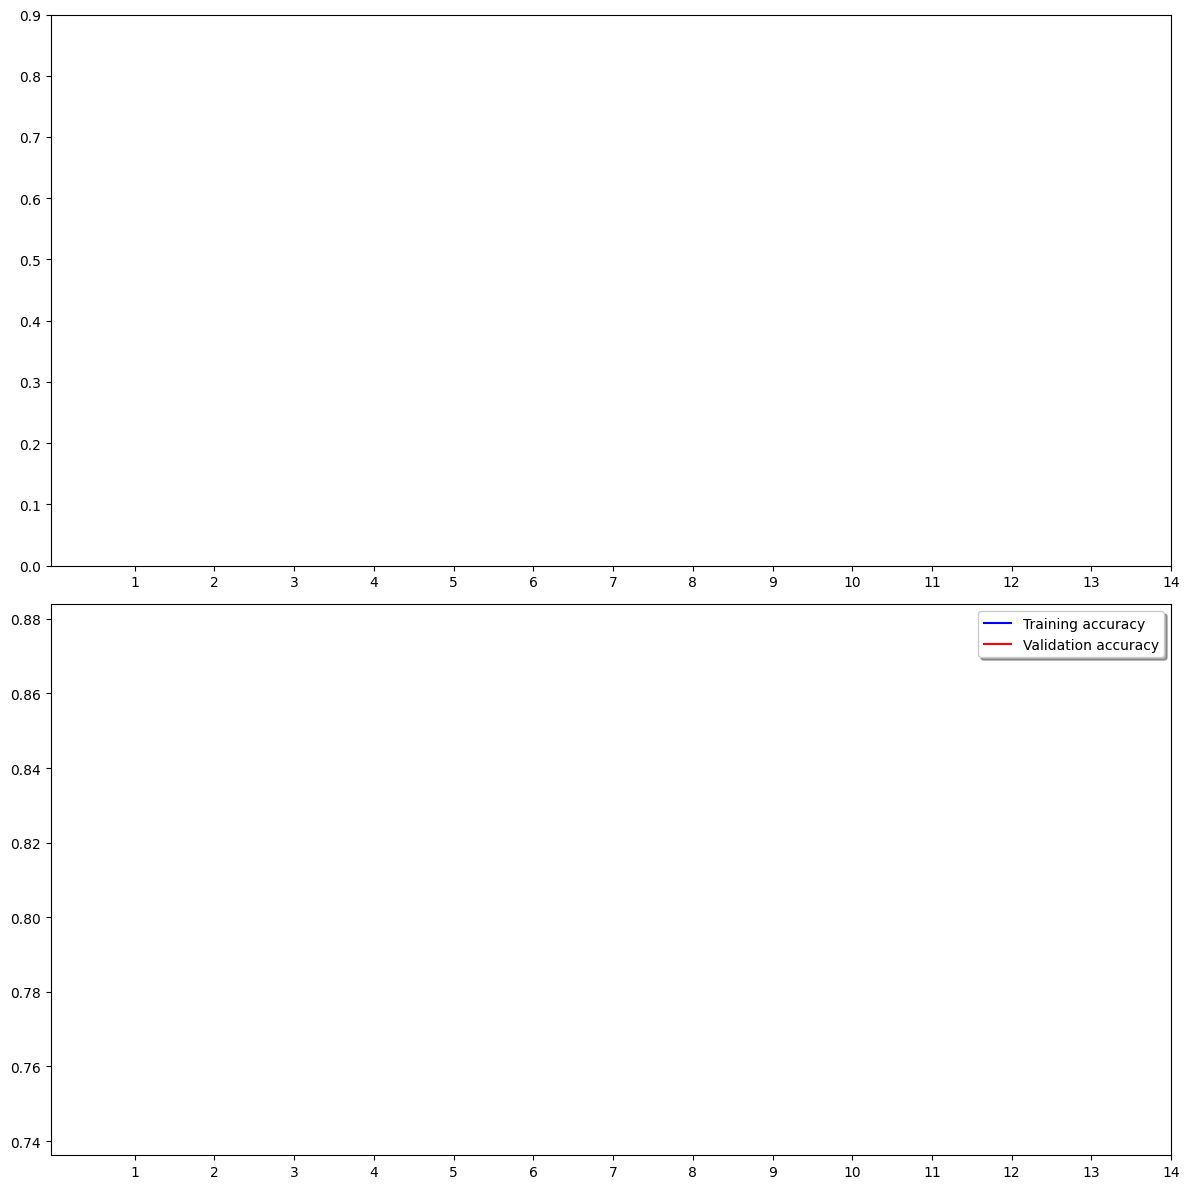

In [57]:
epochs = 15

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [79]:
# os.path.isdir("/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/models")
# model = tf.keras.models.load_model("/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/models/model.h5")
# # model.save_weights("model.h5")

# filepath = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/'

model = tf.keras.models.load_model('/home/paulo/Documents/project-practical-mlops/circuit-board-ml/src/input/saved_model/')

In [80]:
import cv2
path = '/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/organized_data/00041000_temp.jpg'
img = cv2.imread(path)
img = img[...,::-1]                                                                 #give right image or else it will show error
model.predict(img[None,...], batch_size=None, verbose=2, steps=1)

1/1 - 2s - 2s/epoch - 2s/step


array([[0.90142435, 0.09857564]], dtype=float32)

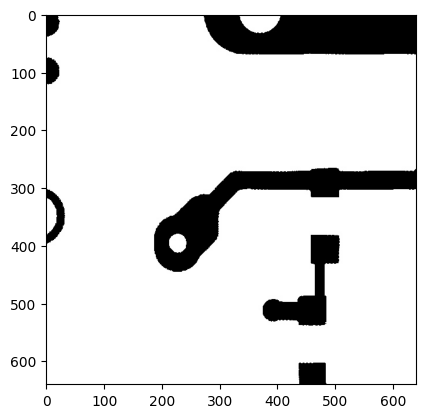

In [81]:
image = preprocessing.image.image_utils.load_img(path)
plt.imshow(image)

In [ ]:
test_filenames = os.listdir(r"/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/organized_data/")
test_df = pd.DataFrame({
    'filename': test_filenames
}).sample(frac=0.1)
nb_samples = test_df.shape[0]

nb_samples

288

In [ ]:
from sklearn.utils import shuffle

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/organized_data", 
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    color_mode ='rgb',
    shuffle=False
)
test_generator

Found 288 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

20/20 [==============================] - 7s 302ms/step


In [ ]:
test_df['label'] = np.argmax(predict, axis=-1)

<AxesSubplot:>

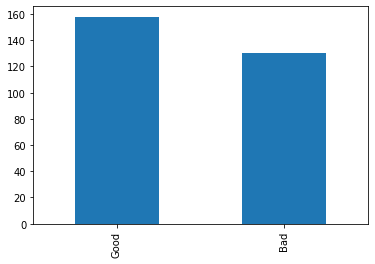

In [ ]:
test_df["label"] = test_df["label"].replace({1: 'Good', 0: 'Bad'})
test_df['label'].value_counts().plot.bar()

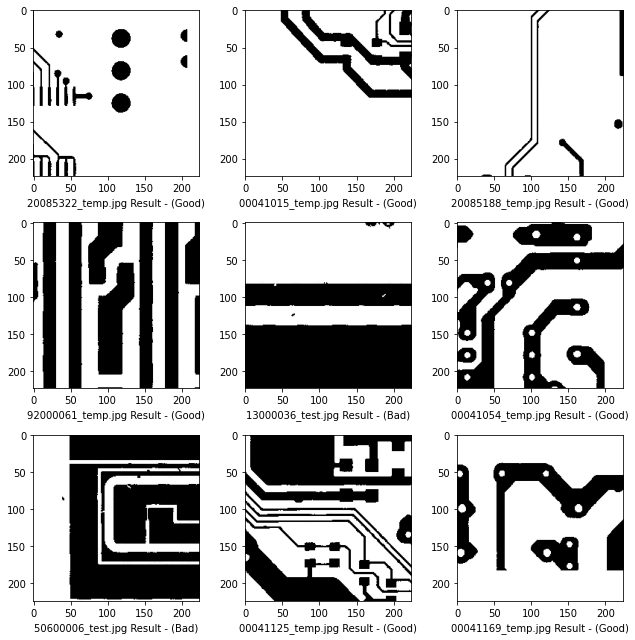

In [ ]:
plt.figure(figsize=(9, 9))
sample_test = test_df.reset_index(drop='index').head(9)
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = preprocessing.image.image_utils.load_img(r"/home/paulo/Documents/project-practical-mlops/circuit-board-ml/notebooks/organized_data/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + (' ') + 'Result - ' + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()